# Instituto de Educação Superior de Brası́lia – IESB
## Pós-Graduação em Inteligência Artificial
### Reconhecimento de Imagens e Visão Computacional

Atividade 01

Turma: 2021-1

Aluno: Henrique Brandão

[Dataset: https://www.kaggle.com/gpiosenka/100-bird-species](https://www.kaggle.com/gpiosenka/100-bird-species)

___

In [1]:
DIR_DADOS = './dados-birds-species'

In [2]:
!ls -l $DIR_DADOS

total 133168
-rw-rw-r--   1 hbrandao hbrandao      9460 nov  2 18:34  class_dict.csv
-rw-rw-r--   1 hbrandao hbrandao 136289360 nov  2 18:34  EfficientNetB3-birds-98.92.h5
drwxrwxr-x   2 hbrandao hbrandao      4096 nov  9 18:35 'images to test'
drwxrwxr-x   2 hbrandao hbrandao      4096 nov  9 18:35 'one image to test'
drwxrwxr-x 317 hbrandao hbrandao     16384 nov  9 18:35  test
drwxrwxr-x 317 hbrandao hbrandao     16384 nov  9 18:35  train
drwxrwxr-x 317 hbrandao hbrandao     16384 nov  9 18:35  valid


In [3]:
!ls -l $DIR_DADOS/train | wc -l

316


In [4]:
!ls -l $DIR_DADOS/test | wc -l

316


In [5]:
!ls -l $DIR_DADOS/valid | wc -l

316


In [6]:
!head -n 4 $DIR_DADOS/class_dict.csv

In [7]:
!tail -n 4 $DIR_DADOS/class_dict.csv

___

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Sequential
from sklearn.metrics import classification_report
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Softmax
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

%matplotlib notebook

In [196]:
PHYS_DEVICE_NAME = tf.config.list_physical_devices('GPU')[0].name[-5:]
PHYS_DEVICE_NAME

'GPU:0'

___

In [197]:
BATCH_SIZE = 32

In [198]:
train_ds = image_dataset_from_directory(
    directory=f'{DIR_DADOS}/train',
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

train_ds

Found 45980 files belonging to 315 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 315)), types: (tf.float32, tf.float32)>

In [207]:
H, W, C = 256, 256, 3

In [199]:
train_ds.class_names[::70]

['AFRICAN CROWNED CRANE',
 'CEDAR WAXWING',
 'GREEN MAGPIE',
 'PAINTED BUNTIG',
 'STRIPPED SWALLOW']

In [200]:
_class_names = train_ds.class_names
imgs, labels = [(i, l) for i,l in train_ds.take(1)][0]

<IPython.core.display.Javascript object>


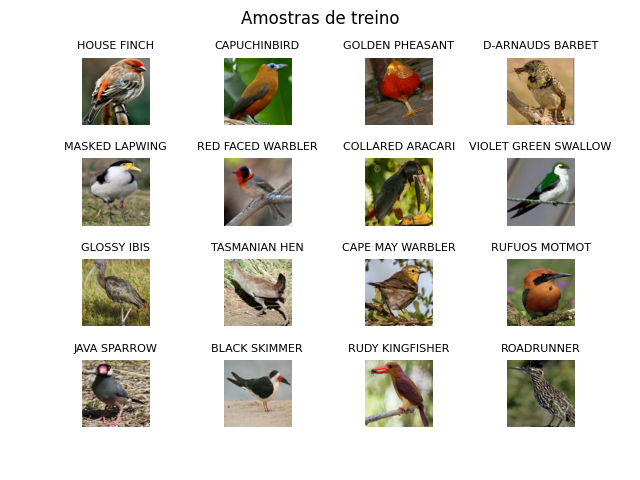

In [201]:
# plt.figure(figsize=(8, 5))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(label=_class_names[np.argmax(labels[i])], fontdict={'fontsize': 8})
    plt.axis("off")
    i += 1

plt.suptitle('Amostras de treino')
plt.subplots_adjust(wspace=1.0, hspace=0.5)
plt.show()

In [202]:
test_ds = image_dataset_from_directory(
    directory=f'{DIR_DADOS}/test',
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_ds

Found 1575 files belonging to 315 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 315)), types: (tf.float32, tf.float32)>

In [203]:
valid_ds = image_dataset_from_directory(
    directory=f'{DIR_DADOS}/valid',
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

valid_ds

Found 1575 files belonging to 315 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 315)), types: (tf.float32, tf.float32)>

___

In [225]:
es = EarlyStopping(monitor='loss',
                   min_delta=1e-10,
                   patience=5, verbose=1)

mcp = ModelCheckpoint(filepath='birds-clf-weights.h5',
                      save_best_only=True,
                      monitor='loss',
                      verbose=1)

rlp = ReduceLROnPlateau(monitor='val_loss',
                        patience = 1,
                        factor=0.5,
                        verbose=1)

In [220]:
def modelo_clf_passaros():
    clf = Sequential()
    clf.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(H, W, C)) )
    clf.add(MaxPool2D())
    clf.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    clf.add(MaxPool2D())
    clf.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=(2, 2)))
    clf.add(MaxPool2D())
    clf.add(Flatten())
    clf.add(Dense(units=128, activation='relu'))
    clf.add(Dense(units=64, activation='relu'))
    clf.add(Dense(units=32, activation='relu'))
    clf.add(Dense(units=315, activation='softmax'))
    clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")
    print(clf.summary())
    return clf    

In [221]:
clf = modelo_clf_passaros()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)            

In [ ]:
with tf.device(device_name=PHYS_DEVICE_NAME):
    K.clear_session()
    hist = clf.fit(train_ds, validation_data=valid_ds,
                    batch_size=32,
                    epochs=10,
                    callbacks=[es, mcp, rlp])

Epoch 1/10
1437/1437 [==============================] - 60s 41ms/step - loss: 5.4739 - accuracy: 0.0162 - val_loss: 5.1705 - val_accuracy: 0.0337

Epoch 00001: loss improved from inf to 5.47386, saving model to birds-clf-weights.h5
Epoch 2/10
1437/1437 [==============================] - 60s 41ms/step - loss: 4.8794 - accuracy: 0.0610 - val_loss: 4.4336 - val_accuracy: 0.1035

Epoch 00002: loss improved from 5.47386 to 4.87942, saving model to birds-clf-weights.h5
Epoch 3/10
 769/1437 [===============>..............] - ETA: 26s - loss: 4.2910 - accuracy: 0.1214

In [ ]:
pred = clf.predict(test_ds)

In [ ]:
LIMIAR = 0.5

In [ ]:
pred = clf.predict(xtest)
pred_argmax = [np.argmax(x) for x in (pred > LIMIAR)]
ytest_argmax = [np.argmax(x) for x in ytest]

Justificativa da estrutura da rede e dos hiperparâmetros:

A foram feitos poucos testes com valores distintos, escolhidos através de forma heurística.
Os valores que costam, bem como a estrutura da rede, resultou em um resultado aceitável.
Não achei necessário efetuar buscas semelhantes a _Grid Search_ para estes elementos, haja vista, não são recomendadas, ou encorajadas, para modelos de _deep learning_.
